In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import os
import numpy as np

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
#class torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)
#transforms.RandomResizedCrop(224) --> A crop of random size (default: of 0.08 to 1.0) of the original size and a 
#random aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. 
#This crop is finally resized to given size (224 in this case). 
#transforms.CenterCrop(224)--> Crops the image at the center. 224 is the Desired output size of the crop.
#class torchvision.transforms.Normalize(mean, std)
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, 
#this transform will normalize each channel of the input torch.Tensor i.e. 
#input[channel] = (input[channel] - mean[channel]) / std[channel]
#Parameters:     mean (sequence) – Sequence of means for each channel.
#                std (sequence) – Sequence of standard deviations for each channel.
dataTransforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:

dataDir = './.dataset/hymenoptera_data'
#Create a dictionary that contains the information of the images in both the training and validation set
imageDatasets = {x: datasets.ImageFolder(os.path.join(dataDir, x),dataTransforms[x]) for x in ['train', 'val']}
#Create a dictionary that contians the data loader
dataLoaders = {x: torch.utils.data.DataLoader(imageDatasets[x], 
                                              batch_size=4,
                                              shuffle=True) for x in ['train', 'val']}

#Create a dictionary that contains the size of each dataset (training and validation)
datasetSizes = {x: len(imageDatasets[x]) for x in ['train', 'val']}
#Get the class names
classNames = imageDatasets['train'].classes
#Print out the results 
print("Class Names: {}".format(classNames))
print("There are {} batches in the training set".format(len(dataLoaders['train'])))
print("There are {} batches in the test set".format(len(dataLoaders['val'])))
print("There are {} training images".format(datasetSizes['train']))
print("There are {} testing images".format(datasetSizes['val']))

Class Names: ['ants', 'bees']
There are 61 batches in the training set
There are 39 batches in the test set
There are 244 training images
There are 153 testing images


In [7]:
#Loading ResNet
model = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/elvingomez/.torch/models/resnet18-5c106cde.pth
46827520it [00:01, 24079477.14it/s]


In [8]:
#Freeze all layers in the network
for param in model.parameters():
    param.requires_grad = False #pytorch is not propagating when we set this to False

In [10]:
#Get the number of inputs of the last layer (num of neurons in the layer preceeding last layer)
numOfFeatures = model.fc.in_features
#REconstruct the last layer (output) in order to have only 2 classes
model.fc = nn.Linear(numOfFeatures, 2)

In [11]:
if torch.cuda.is_available():
    model = model.cuda()

In [12]:
#understand what's happening
iteration = 0
correct = 0
for inputs, labels in dataLoaders['train']:
    if iteration == 1:
        break
    inputs = Variable(inputs)
    labels = Variable(labels)
    if torch.cuda.is_available():
        inputs.cuda_()
        labels.cuda_()
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape) #[4, 3, 224, 224] bs, channels(rgb), height, width
    print("Labels Shape:",labels.shape)
    print("Labels are: {}".format(labels))
    output = model(inputs)
    print("Output Tensor:", output)
    print("Outputs Shape",output.shape)
    _, predicted = torch.max(output, 1) #softmax
    print("Predicted:", predicted)
    print("Predicted Shape",predicted.shape)
    correct += (predicted == labels).sum()   
    print("Correct Predictions:",correct)
    
    iteration += 1

For one iteration, this is what happens:
Input Shape: torch.Size([4, 3, 224, 224])
Labels Shape: torch.Size([4])
Labels are: tensor([0, 0, 0, 1])
Output Tensor: tensor([[-0.3860,  0.7896],
        [ 0.1212,  0.8561],
        [-0.4574,  0.5782],
        [-0.1728,  0.8020]], grad_fn=<AddmmBackward>)
Outputs Shape torch.Size([4, 2])
Predicted: tensor([1, 1, 1, 1])
Predicted Shape torch.Size([4])
Correct Predictions: tensor(1)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
#Try: optim.Adam(model_conv.fc.parameters(), lr=0.001)

#Decay LR by a factor of 0.1 every 7 epochs
lrScheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
numOfEpochs = 25
for epoch in range (numOfEpochs):
    lrScheduler.step()
    correct = 0 #reset
    for images, labels in dataLoaders['train']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            inputs.cuda_()
            labels.cuda_()
            
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
    trainAcc = 100 * correct / datasetSizes['train']    
    print ('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {}%'
            .format(epoch+1, numOfEpochs, loss.item(), trainAcc))
        

Epoch [1/25], Loss: 0.3505, Train Accuracy: 68%
Epoch [2/25], Loss: 0.1573, Train Accuracy: 81%
Epoch [3/25], Loss: 0.2051, Train Accuracy: 69%
Epoch [4/25], Loss: 0.0969, Train Accuracy: 79%
Epoch [5/25], Loss: 0.9944, Train Accuracy: 78%
Epoch [6/25], Loss: 0.0457, Train Accuracy: 86%
Epoch [7/25], Loss: 2.1107, Train Accuracy: 77%
Epoch [8/25], Loss: 0.0033, Train Accuracy: 77%
Epoch [9/25], Loss: 0.0950, Train Accuracy: 83%
Epoch [10/25], Loss: 1.1390, Train Accuracy: 84%
Epoch [11/25], Loss: 0.0097, Train Accuracy: 82%
Epoch [12/25], Loss: 0.5528, Train Accuracy: 86%
Epoch [13/25], Loss: 0.0663, Train Accuracy: 83%
Epoch [14/25], Loss: 0.2158, Train Accuracy: 87%
Epoch [15/25], Loss: 0.3457, Train Accuracy: 84%
Epoch [16/25], Loss: 0.4040, Train Accuracy: 90%
Epoch [17/25], Loss: 0.1181, Train Accuracy: 82%
Epoch [18/25], Loss: 0.4665, Train Accuracy: 86%
Epoch [19/25], Loss: 1.1193, Train Accuracy: 86%
Epoch [20/25], Loss: 0.0318, Train Accuracy: 84%
Epoch [21/25], Loss: 0.0690, 

In [16]:
# Test the model
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for (images, labels) in dataLoaders['val']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy: {:.3f} %'.format(100 * correct / total))

Test Accuracy: 94.118 %


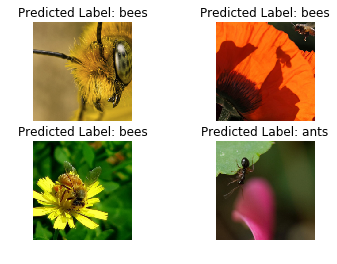

In [19]:
#Visualize some predictions 
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
    for (images, labels) in dataLoaders['val']:
        if shown_batch == 1:
            break
        shown_batch += 1
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model(images)                            #The output is of shape (4,2)
        _, preds = torch.max(outputs, 1)                        #The pred is of shape (4) --> [ 0,  0,  0,  1]
        
        for i in range(4):
            index += 1
            ax = plt.subplot(2,2,index)
            ax.axis('off')
            ax.set_title('Predicted Label: {}'.format(classNames[preds[i]]))
            input_img = images.cpu().data[i]                    #Get the tensor of the image, and put it to cpu  
            inp = input_img.numpy().transpose((1, 2, 0))        #If we have a tensor of shape (2,3,4) --> it becomes (3,4,2)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)